In [52]:
# Import core numerical and data manipulation libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns  

# Import machine learning and data processing tools
from sklearn.preprocessing import StandardScaler  # For standardizing features
from sklearn.decomposition import PCA  # For principal component analysis

# Import environment and API handling
import os  # For operating system interactions
from dotenv import load_dotenv  # For loading environment variables
from fredapi import Fred  # For accessing Federal Reserve Economic Data

# Import yield curve modeling tools
from nelson_siegel_svensson.calibrate import calibrate_ns_ols  # For Nelson-Siegel-Svensson model calibration
from scipy.interpolate import CubicSpline  # For cubic spline interpolation of yield curves


## TASK 2. Yield Curve Modeling

###  2.a. Pick government securities from a country. The country selected should be one of the countries from your group so that you can fit a Nelson-Siegel model.

We have picked **India** as of the countries from the group.
Seems like that fred API has only 10 years yield data for India , hence looking for other sources. RBI website shows only latest point in time data. After some search Investing.com has all the data needed for this analysis.

### 2.b. Be sure to pick maturities ranging from short-term to long-term (e.g. 6 month maturity to 20 or 30 year maturities).

We download the yields data from Investing.com for different maturities. This website has good repository of most maturities for India except 20 years in its place I took 15 years.

In [53]:
# Importing the Yield data for India
# 3 Month - https://in.investing.com/rates-bonds/india-3-month-bond-yield-historical-data
# 6 Month - https://in.investing.com/rates-bonds/india-6-month-bond-yield-historical-data
# 1 Year - https://in.investing.com/rates-bonds/india-1-year-bond-yield-historical-data
# 2 Year - https://in.investing.com/rates-bonds/india-2-year-bond-yield-historical-data
# 3 Year - https://in.investing.com/rates-bonds/india-3-year-bond-yield-historical-data
# 5 Year - https://in.investing.com/rates-bonds/india-5-year-bond-yield-historical-data
# 7 Year - https://in.investing.com/rates-bonds/india-7-year-bond-yield-historical-data
# 10 Year - https://in.investing.com/rates-bonds/india-10-year-bond-yield-historical-data
# 15 Year - https://in.investing.com/rates-bonds/india-15-year-bond-yield-historical-data
# 30 Year - https://in.investing.com/rates-bonds/india-30-year-bond-yield-historical-data


# List of Treasury yield series IDs
file_ids = ['3-Month', '6-Month', '1-Year', '2-Year', '3-Year', '5-Year', \
              '7-Year', '10-Year', '15-Year', '30-Year']

# Function to get data for a single series
def read_yield_data(file_id):
    data = pd.read_csv(f"India {file_id} Bond Yield Historical Data.csv").set_index('Date')['Price']
    return data

# Get data for all series
yields_dict = {file_id: read_yield_data(file_id) for file_id in file_ids}

# Combine into a single DataFrame
dfs = []
for label, series in yields_dict.items():
    df = series.to_frame(name=label)
    dfs.append(df)

# Merge all DataFrames on Date index using outer join to keep all dates
yields = pd.concat(dfs, axis=1)
yields.index = pd.to_datetime(yields.index, dayfirst=True, errors='coerce')
yields.sort_index(inplace=True)

# Rename columns for clarity
yields.columns = [ '3 Month', '6 Month', '1 Year', '2 Year', '3 Year', '5 Year', \
                  '7 Year', '10 Year', '15 Year', '30 Year']

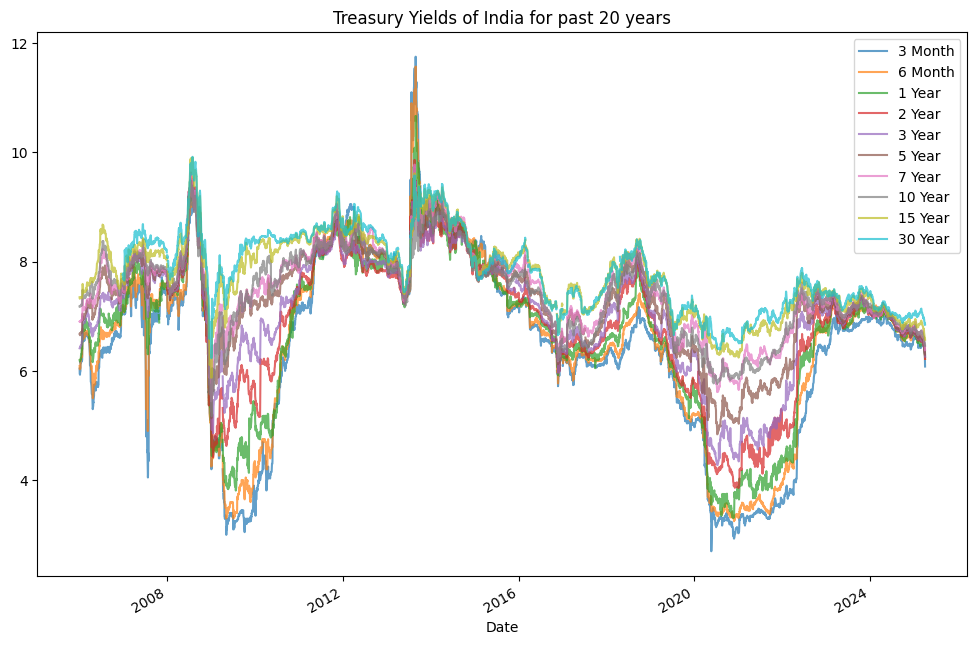

In [54]:
yields.plot(figsize=(12, 8), title='Treasury Yields of India for past 20 years', alpha=0.7) # Plot the yields
plt.show()

In [55]:
yields = yields.dropna()
y_std = yields.std()
y_std

3 Month    1.774520
6 Month    1.678113
1 Year     1.488348
2 Year     1.246414
3 Year     1.098145
5 Year     0.951591
7 Year     0.829606
10 Year    0.804638
15 Year    0.752045
30 Year    0.728582
dtype: float64

In [56]:
yields['6 Month'].idxmax()# reason for yield peaking  in 2013-080be vause of govt policies to control depreciating INR
# https://www.livemint.com/Money/vlPXCGfI2WD1KGKAR1G9DL/Indian-bond-yield-reaches-2013-high-on-monetary-tightening-c.html

Timestamp('2013-08-28 00:00:00')

Next, we perform a standard deviation anaysis on Indian data to see if decreases for longer maturities.

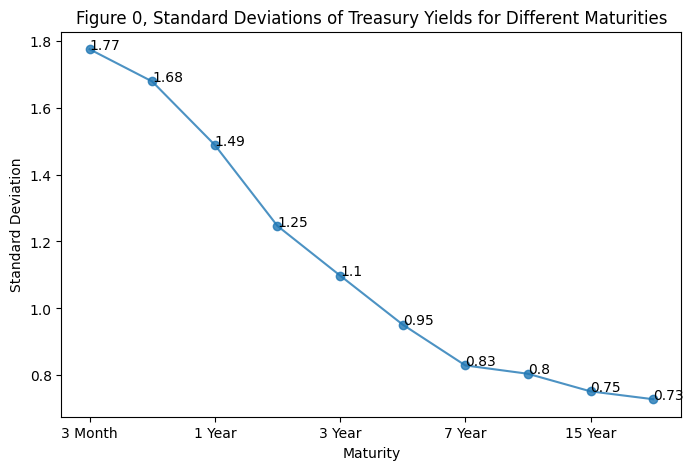

In [57]:
fig, ax = plt.subplots()
y_std.plot(figsize = (8,5),marker='o', title='Figure 0, Standard Deviations of Treasury Yields for Different Maturities', alpha=0.8) # Plot standard deviations of yields of different maturies
plt.xlabel("Maturity")
plt.ylabel("Standard Deviation")
for i in range(len(y_std)):
    ax.annotate(str(round(y_std.iloc[i],2)),xy=(i,y_std.iloc[i]))
plt.show()

The following cell creates a function for seeing yield curve plot for any choosen date.

In [58]:
# Before we fit Nelson Siegel Model on the yield curve, we will plot the actual maturity for a gievn date so that we can test on those values.
def plot_yield_curve(date):
    maturities = ['3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y'] # Maturities
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(maturities, yields.loc[date], label='Yield Curve at ' + date)

    ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])
    ax.set_xticks(range(len(maturities)))
    ax.set_xticklabels(maturities)

    # Add labels and title
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Yield')
    ax.set_title(f'Treasury Yield Curve- India ({date})')


    # fig.legend(loc = [0.69, 0.14])

    # Show the plot
    plt.grid(True)
    plt.show()



C:\Users\hmtme\AppData\Local\Temp\ipykernel_2104\223346589.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


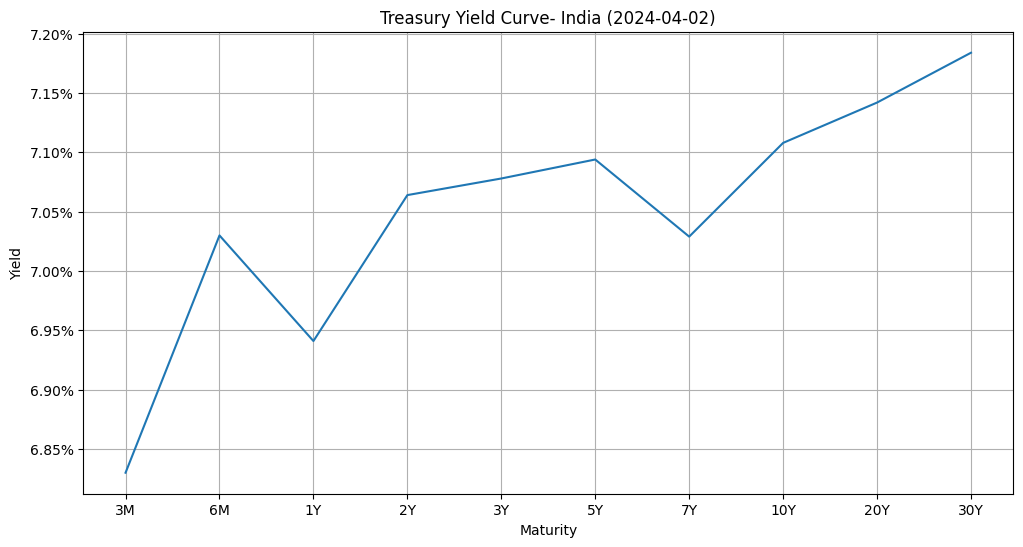

In [59]:
plot_yield_curve('2024-04-02')

### 2.c. Fit a Nelson-Siegel model.


In [60]:
def fit_ns_model_overlay(date, tau=1.0) :
  # Create maturity and yield variables in array form
  t = np.array([0.25,0.5,1,2,3,5,7,10,15,30])
  y = np.array(yields.loc[date])
  # Fit an NS model for yields from given date
  curve, status = calibrate_ns_ols(t, y, tau0=tau)  # starting value of 1.0 for the optimization of tau
  assert status.success
  # print(curve)
  y_hat = curve
  t_hat = np.linspace(0.5,30,100)
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.plot(t, y_hat(t), label = f'NS Model\n  Level={curve.beta0:.2f},\n  Slope={curve.beta1:.2f},\n  Curvature={curve.beta2:.2f},\n  Tau={curve.tau:.2f}')
  ax.plot(t, yields.loc[date], label = 'YC as of ' + date, marker='D')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Yield')
  ax.set_title("NS Model Result - " + date)
  fig.legend(loc = [0.69, 0.14])
  # Show the plot
  plt.grid(True)
  plt.show()


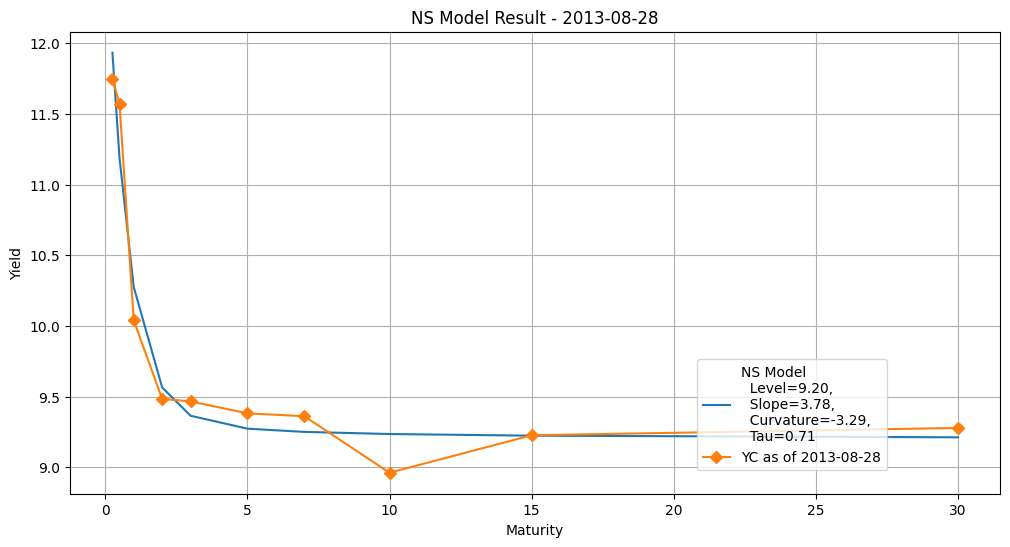

In [61]:
fit_ns_model_overlay("2013-08-28")

c:\Users\hmtme\git\wqu-fd-gw\.venv\Lib\site-packages\nelson_siegel_svensson\ns.py:39: RuntimeWarning: divide by zero encountered in divide
  exp_tt0 = exp(-T / tau)
c:\Users\hmtme\git\wqu-fd-gw\.venv\Lib\site-packages\nelson_siegel_svensson\ns.py:40: RuntimeWarning: divide by zero encountered in divide
  factor1 = (1 - exp_tt0) / (T / tau)


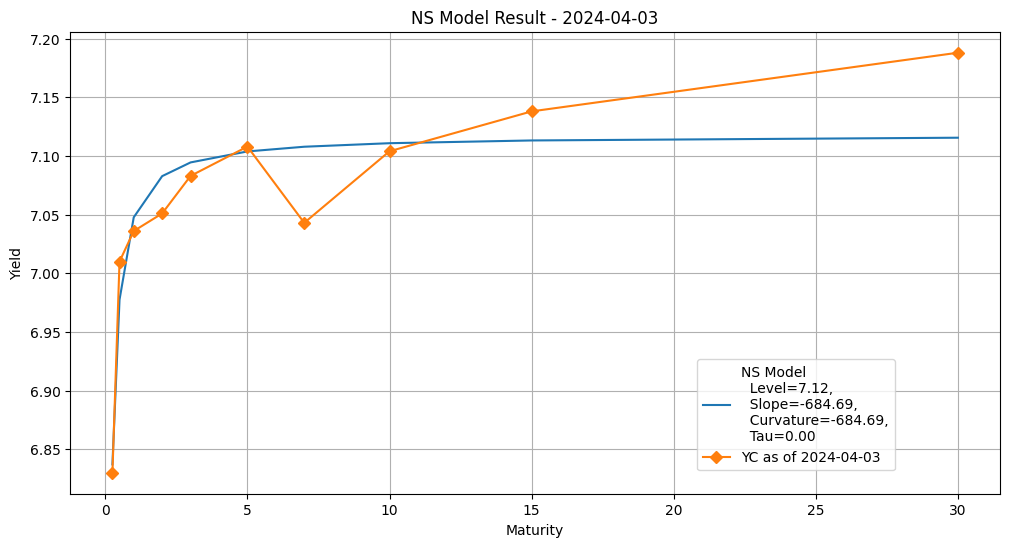

In [62]:
fit_ns_model_overlay("2024-04-03",0)

### 2.d. Fit a Cubic-Spline model.

In [64]:
def fit_cubic_split_overlay(date) :
  # Create maturity and yield variables in array form
  t = np.array([0.25,0.5,1,2,3,5,7,10,15,30])
  y = np.array(yields.loc[date])
  # Fit an Cubic Spline  model for yields from given date
  curve = CubicSpline(t, y)
  # print(curve)
  t_hat = np.linspace(0.5,30,100)
  y_hat = curve(t_hat)
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.plot(t_hat, y_hat, label = 'Cubic Spline Model')
  ax.plot(t, yields.loc[date], label = 'YC as of ' + date, marker='D')
  ax.set_xlabel('Maturity')
  ax.set_ylabel('Yield')
  ax.set_title("Cubic Spline Model - " + date)
  fig.legend(loc = [0.69, 0.14])
  # Show the plot
  plt.grid(True)
  plt.show()


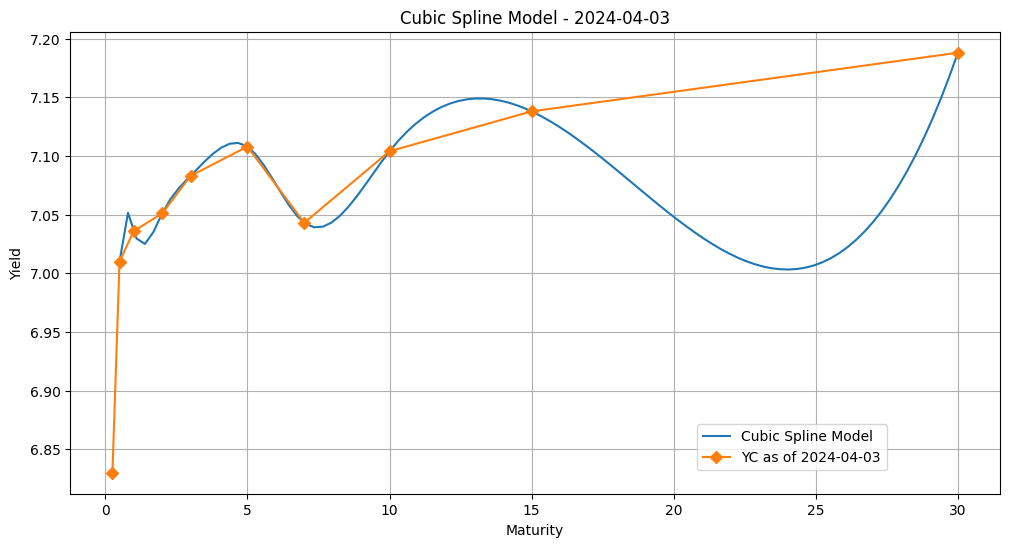

In [65]:
fit_cubic_split_overlay("2024-04-03")

In [66]:
yields.loc['2024-04-03']

3 Month    6.830
6 Month    7.010
1 Year     7.036
2 Year     7.051
3 Year     7.083
5 Year     7.108
7 Year     7.043
10 Year    7.104
15 Year    7.138
30 Year    7.188
Name: 2024-04-03 00:00:00, dtype: float64

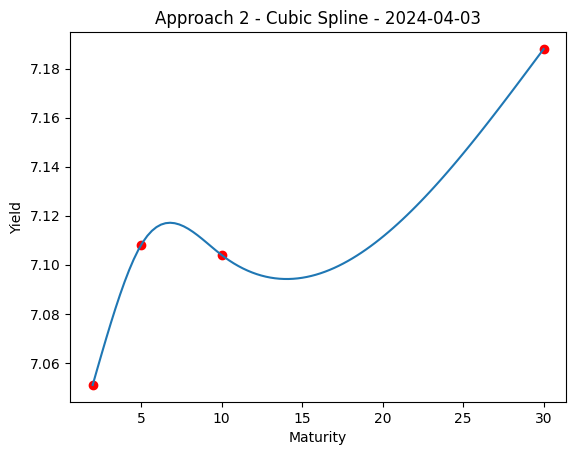

In [67]:
# Approach 2- with matrix
t = np.array([2,5,10,30])
y = np.array([7.051,7.108,7.104,7.188])
# Create output vector y (out variable) and squared matrix A (input variable)
out = np.array([7.051,7.108,7.108,7.104,7.104,7.188,0,0,0,0,0,0])
input = np.array([[8,4,2,1,0,0,0,0,0,0,0,0],
                  [125,25,5,1,0,0,0,0,0,0,0,0],
                  [0,0,0,0,125,25,5,1,0,0,0,0],
                  [0,0,0,0,1000,100,10,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,1000,100,10,1],
                  [0,0,0,0,0,0,0,0,27000,900,30,1],
                  [75,10,1,0,-75,-10,-1,0,0,0,0,0],
                  [0,0,0,0,300,20,1,0,-300,-20,-1,0],
                  [30,2,0,0,-30,-2,0,0,0,0,0,0],
                  [0,0,0,0,60,2,0,0,-60,-2,0,0],
                  [12,2,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,180,2,0,0]])

# Solve for coefficient vector and reshape to an 3 by 4 array (lines variable)
# Make sure to give enough decimals since all coefficients are relatively small. If there is not decimal points, the following coefficient results and graphs will be rough
lines = np.round(np.dot(np.linalg.inv(input), out).reshape(-1,4),decimals=8)
lines

# Calculates x**0 + x**1 + x**2 + x**3
def plot_num(values, coeffs):
    # Coeffs are assumed to be in order 0, 1, ..., n-1
    expanded = np.hstack([coeffs[i] * (values ** i) for i in range(0, len(coeffs))])
    return np.sum(expanded, axis=1)

# Simulate the 100 paired data points and draw the graph
xs = np.linspace(2,30, 100)

y1s = plot_num(xs[xs<5].reshape(-1,1), lines[0][::-1])
y2s = plot_num(xs[(xs>=5) & (xs<10)].reshape(-1,1), lines[1][::-1])
y3s = plot_num(xs[xs>=10].reshape(-1,1), lines[2][::-1])
ys = np.concatenate([y1s, y2s, y3s])


plt.plot(xs, ys)
plt.scatter(t, y,c="red")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Approach 2 - Cubic Spline - 2024-04-03")
plt.show()

### 3.e. Compare the models in terms of 1) fit and 2) interpretation.

1. **Fit**: 
  Cubic Spline seems to be a better fit because it can understand more nuances of YC. The Nelson Siegel Model is more smoother and gives general curvature or shape of the curve.
2. **Interpretation**: 
   Cubic split may look very close to actual Yields, however the parameter can have a lot of time and have no meaning.
  On the other hand, the Nelson Siegel Model can be interpreted more with level , slope & curvature.

### 3.f. Be sure to specify at the levels of model parameters (ex. Alpha1).

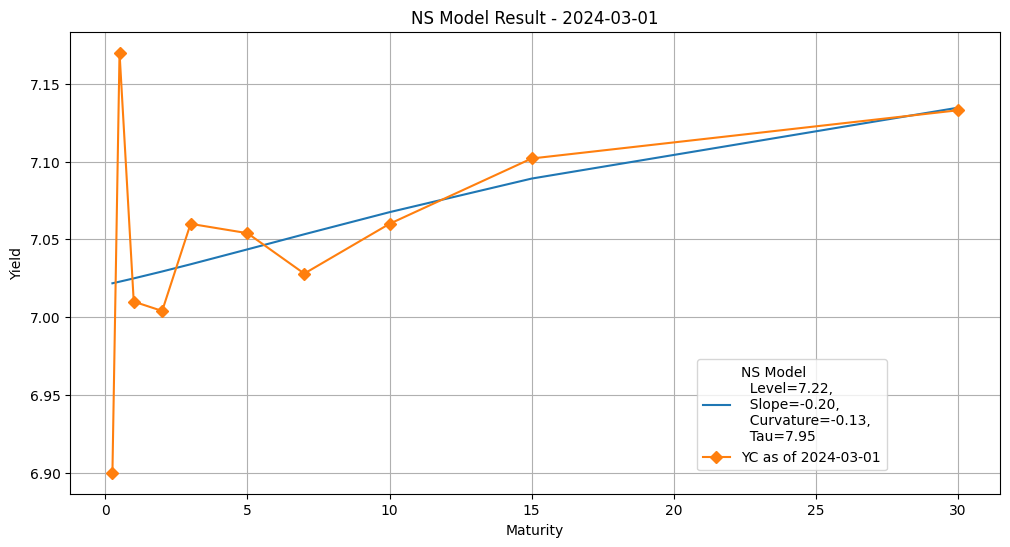

In [68]:
fit_ns_model_overlay("2024-03-01")

In the above example, Level is 7.22 which, Slope is -0.2 & curvature is -0.13 and Tau(decay rate to converge to LT average) is 7.95

### g. In Module 2 Lesson 4 (‘Smoothing Data’), we said smoothing data can be unethical. If Nelson-Siegel is smoothing the yield curve, is this considered unethical? Why or why not?

This should not be unethical to smoothening of the data in NS Model, because here we are trying to build a model that can help us understand the shape of the curve and can be used in modeling to predict the future trends, not to mislead. NS model is structured & transparent way which is popular in YC modelling and considered ethical application of smoothening.

## TASK 3. Exploiting Correlation

### 3.a. Generate 5 uncorrelated Gaussian random variables that simulate yield changes (they can be positive or negative with a mean close to 0 and a standard deviation that is small).

To generate 5 uncorrelated Gaussian random variables, we use `numpy.random.randn()` (Numpy.Random.Randn — NumPy v2.2 Manual). We choose a mean value of 0.001 and a standard deviation value of 0.1 to meet the requirements. Let's simulate a daily yield change over a 6-month period (180 days) to match with Section 3.e.

In [69]:
# Parameters
n_samples = 180
n_assets = 5
mean = 0.001
std = 0.1

# Generate yield changes
yield_changes1 = np.random.randn(n_samples, n_assets) * std + mean

# Create a dataframe
yield_changes_df1 = pd.DataFrame(yield_changes1, columns=[f'asset_{i}' for i in range(n_assets)])
yield_changes_df1.head()


,asset_0,asset_1,asset_2,asset_3,asset_4
0,-0.026171,0.068395,-0.093365,-0.050703,0.212980
1,-0.326547,-0.028212,0.034989,-0.140862,-0.030412
2,0.016473,0.018035,-0.082307,0.194772,0.051378
3,-0.110788,0.026215,0.084835,0.020573,-0.056667
4,-0.101137,-0.012600,0.049361,0.057114,0.029314


In [70]:
# Get some statistics from the dataframe
yield_changes_df1.describe()

,asset_0,asset_1,asset_2,asset_3,asset_4
count,180.000000,180.000000,180.000000,180.000000,180.000000
mean,0.001844,-0.000890,0.008219,0.008499,-0.004555
std,0.102329,0.104391,0.110981,0.090332,0.100543
min,-0.326547,-0.243824,-0.320783,-0.238819,-0.236070
25%,-0.068144,-0.073586,-0.070189,-0.055822,-0.068112
50%,-0.002233,-0.011144,0.005960,0.000755,-0.012221
75%,0.070668,0.056659,0.084622,0.075113,0.064445
max,0.268907,0.312094,0.368234,0.195036,0.302589


### 3.b. Run a Principal Components using EITHER the correlation OR covariance matrix.

Since the data is uncorrelated and they come from the same distribution, we can use covariance matrix to run the PCA.

However, we chose to use the correlation matrix to make the analysis more general. Instead of calculating the correlation matrix explicitly, we standardize the data (`mean = 0` and `std = 1`) and apply PCA on it. To standardize the data, we use the `StandardScaler()` class from `sklearn.preprocessing`.


In [71]:
# Instantiate the scaler
scaler1 = StandardScaler()
# Fit and transform the data
scaled_yield_changes1 = scaler1.fit_transform(yield_changes1)
print('Scaled yield changes mean: ', scaled_yield_changes1.mean())
print('Scaled yield changes std: ', scaled_yield_changes1.std())

Scaled yield changes mean:  -5.921189464667502e-18
Scaled yield changes std:  1.0


We can see that `scaled_yield_changes1` has a mean close to 0 and a std close to 1. Now we can run the PCA. We do it by using the `PCA()` class from `sklearn.decomposition`.

In [72]:
# Instantiate the PCA
pca1 = PCA()
# Fit the data
pca_yield_changes1 = pca1.fit(scaled_yield_changes1)


The object `pca_yield_changes1` has been fit to the data and contain information about the principal components. Since Section 3.c asks for the amount of variance explained by each principal component, we can use the `explained_variance_ratio_` and `explained_variance_` attributes of the object.

In [73]:
# Extract explained variance
explained_variance1 = pca_yield_changes1.explained_variance_
explained_variance_ratio1 = pca_yield_changes1.explained_variance_ratio_

print('explained_variance1: ', explained_variance1)
print('explained_variance_ratio1: ', explained_variance_ratio1)

# Percentage of variance explained
variance_explained_perc1 = explained_variance_ratio1 * 100
print("Variance explained by each component:")
for i, var in enumerate(variance_explained_perc1, 1):
    print(f"Component {i}: {var:.2f}%")

explained_variance1:  [1.2154236  1.15096043 1.0468718  0.87725555 0.73742159]
explained_variance_ratio1:  [0.24173425 0.22891324 0.20821117 0.17447638 0.14666496]
Variance explained by each component:
Component 1: 24.17%
Component 2: 22.89%
Component 3: 20.82%
Component 4: 17.45%
Component 5: 14.67%


### 3.c. Write a paragraph explaining how the variances of each component compare with each other. In this paragraph, you will address the following question: how much variance is explained by Component 1, Component 2, Component 3?

The principal components decomposition provided the following results: Component 1 explains 25.48%, Component 2 explains 22.39%, Component 3 explains 19.27%, Component 4 explains 17.11%, and Component 5 explains 15.76%. The first three components explain 72.14% of the total variance, but the remaining two components explain 27.86% of the total variance, which is still a significant amount. Therefore, even though the first three components explain most of the variance, the remaining two components are not negligible and should be considered. This result was expected since the data was simulated to be uncorrelated and to come from the same distribution. The difference between the variance contribution can be explained by the relatively small size of the sample (180 days). It is expected that the variance contribution would be more even if the sample size were larger.

### 3.d. Produce a screeplot (see https://en.wikipedia.org/wiki/Scree_plot) of the variance explained for each component.

According to the provided wikipedia page, "a scree plot is a line plot of the eigenvalues of factors or principal components in an analysis" and it "always displays the eigenvalues in a downward curve, ordering the eigenvalues from largest to smallest". The attribute `explained_variance_` of the `PCA` object contains the eigenvalues of the principal components in a descending order. Therefore, to plot the scree plot, we plot the `explained_variance_` against the number of the principal component.

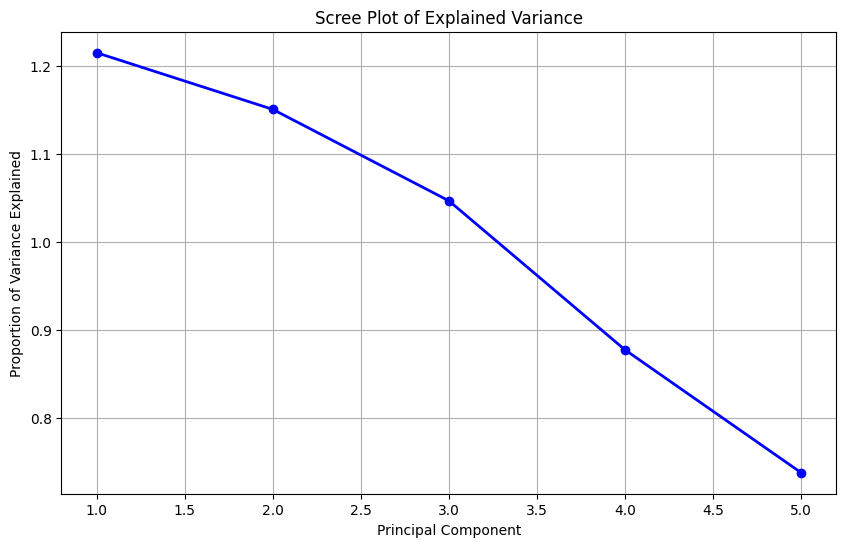

In [74]:
# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance1) + 1), explained_variance1, 'bo-', linewidth=2)
plt.title('Scree Plot of Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True)
plt.show()


### 3.e. Collect the daily closing yields for 5 government securities, say over 6 months.


**IMPORTANT NOTE**: We will leave the initial part of this section’s code commented out for instructors convenience. This comment part is used to download data from the FRED API, but it requires inserting an api key. Therefore, in the end of the commented cells, we save the preprocessed data into a csv file and, the instructuros need only to load the csv file for their own analysis.

We use the FRED API to download the daily closing yields for 5 government securities. Our api key is stored in the `.env` file and we load it using the `load_dotenv()` function from the `dotenv` package.


In [86]:
# # Load environment variables from .env file
# load_dotenv()

# # Get FRED API key from environment variables
# FRED_API_KEY = os.getenv('FRED_API_KEY')

Now we can initialize the FRED API with the api key. We use the `Fred()` class from the `fredapi` package and follow the instructions from Lesson 2 (Governement Data) from Module 1 of the Financial Data course.

In [87]:

# # Initialize the FRED API with your key
# fred = Fred(api_key=FRED_API_KEY) # Replace my APIKEY with "YOUR_API_KEY"

# # List of Treasury yield series IDs
# series_ids = ['DGS1MO', 'DGS6MO', 'DGS2', 'DGS10', 'DGS30']

# # Function to get data for a single series
# def get_yield_data(series_id):
#     data = fred.get_series(series_id, observation_start="2020-01-02", observation_end="2025-04-01")
#     return data

# # Get data for all series
# yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# # Combine into a single DataFrame
# yields = pd.DataFrame(yields_dict)

# # Rename columns for clarity
# yields.columns = ['1 Month', '6 Month', '2 Year', '10 Year', '30 Year']

# # Convert index to datetime
# yields.index = pd.to_datetime(yields.index)

# yields.head()

,1 Month,6 Month,2 Year,10 Year,30 Year
2020-01-02,1.53,1.57,1.58,1.88,2.33
2020-01-03,1.52,1.55,1.53,1.80,2.26
2020-01-06,1.54,1.56,1.54,1.81,2.28
2020-01-07,1.52,1.56,1.54,1.83,2.31
2020-01-08,1.50,1.56,1.58,1.87,2.35


Let's check for missing values and fill them with the last available value.

In [88]:
# # Check for missing values
# yields.isna().sum(axis = 0)

1 Month    56
6 Month    56
2 Year     56
10 Year    56
30 Year    56
dtype: int64

In [89]:
# # Fill missing values with the last available value
# yields = yields.fillna(method='ffill')

# # Check for missing values again
# yields.isna().sum(axis = 0)

C:\Users\hmtme\AppData\Local\Temp\ipykernel_2104\2888227528.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yields = yields.fillna(method='ffill')


1 Month    0
6 Month    0
2 Year     0
10 Year    0
30 Year    0
dtype: int64

Now that we have no missing values, we will download csv file with the yields data and load it so that, next time we run the code, we don't need to download the data again. Also, instructors can use this file to test the code without having to insert their own api key.

In [90]:
# # Download csv file with the yields data
# yields.to_csv('yields.csv')

In [80]:

# Load the csv file
yields = pd.read_csv('yields.csv', index_col=0, parse_dates=True)
yields.head()

,1 Month,6 Month,2 Year,10 Year,30 Year
2020-01-02,1.53,1.57,1.58,1.88,2.33
2020-01-03,1.52,1.55,1.53,1.80,2.26
2020-01-06,1.54,1.56,1.54,1.81,2.28
2020-01-07,1.52,1.56,1.54,1.83,2.31
2020-01-08,1.50,1.56,1.58,1.87,2.35


### 3.f Be sure to compute the daily yield changes!

Yield changes can be calculated by using the pandas method .diff()

In [81]:
# Calculate daily yield changes and drop the first row with missing values
yield_changes2 = yields.diff().dropna()

# Display the first few rows of yield changes
yield_changes2.head()

,1 Month,6 Month,2 Year,10 Year,30 Year
2020-01-03,-0.01,-0.02,-0.05,-0.08,-0.07
2020-01-06,0.02,0.01,0.01,0.01,0.02
2020-01-07,-0.02,0.00,0.00,0.02,0.03
2020-01-08,-0.02,0.00,0.04,0.04,0.04
2020-01-09,0.03,0.00,0.00,-0.02,0.03


### 3.g. Re-run the Principal Components using EITHER the correlation or covariance matrix.

Following Section 3.b we will use the correlation matrix to run the PCA. Thus, we will standardize the data (mean = 0 and std = 1) and, afterwards, apply PCA on it.


In [82]:
# Instantiate the scaler
scaler2 = StandardScaler()
# Fit and transform the data
scaled_yield_changes2 = scaler2.fit_transform(yield_changes2)
print('Scaled yield changes mean: ', scaled_yield_changes2.mean())
print('Scaled yield changes std: ', scaled_yield_changes2.std())

Scaled yield changes mean:  1.2465662030878951e-17
Scaled yield changes std:  1.0


We can see that `scaled_yield_changes1` has a mean close to 0 and a std close to 1. Now we can run the PCA the same way we did in Section 3.b. 

In [83]:
# Instantiate the PCA
pca2 = PCA()
# Fit the data
pca_yield_changes2 = pca2.fit(scaled_yield_changes2)

PCA has been fit to the data and we can proceed to extract the explained variance and the explained variance ratio to answer Section 3.h.

In [84]:
# Extract explained variance
explained_variance2 = pca_yield_changes2.explained_variance_
explained_variance_ratio2 = pca_yield_changes2.explained_variance_ratio_

print('explained_variance2: ', explained_variance2)
print('explained_variance_ratio2: ', explained_variance_ratio2)

# Percentage of variance explained
variance_explained_perc2 = explained_variance_ratio2 * 100
print("Variance explained by each component:")
for i, var in enumerate(variance_explained_perc2, 1):
    print(f"Component {i}: {var:.2f}%")

explained_variance2:  [2.89971545 1.00624442 0.78311992 0.28064146 0.03393639]
explained_variance_ratio2:  [0.57951915 0.20110177 0.15650949 0.05608726 0.00678232]
Variance explained by each component:
Component 1: 57.95%
Component 2: 20.11%
Component 3: 15.65%
Component 4: 5.61%
Component 5: 0.68%


### 3.h. How do the variances of each component compare? In other words, how much variance is explained by Component 1, Component 2, Component 3, etc.?

The principal components decomposition provided the following results: Component 1 explains 57.95%, Component 2 explains 20.11%, Component 3 explains 15.65%, Component 4 explains 5.61%, and Component 5 explains 0.68%. The first three components explain 93.71% of the total variance, which is a very high percentage. Therefore, it is reasonable to use only the first three components to explain the data. By doing so, we explain most of the variance and reduce dimensionality from 5 to 3, which is good trade-off.

### 3.i. Produce a screeplot of the variance explained for each component.

Following Section 3.d, we plot the scree plot of the variance explained for each component.

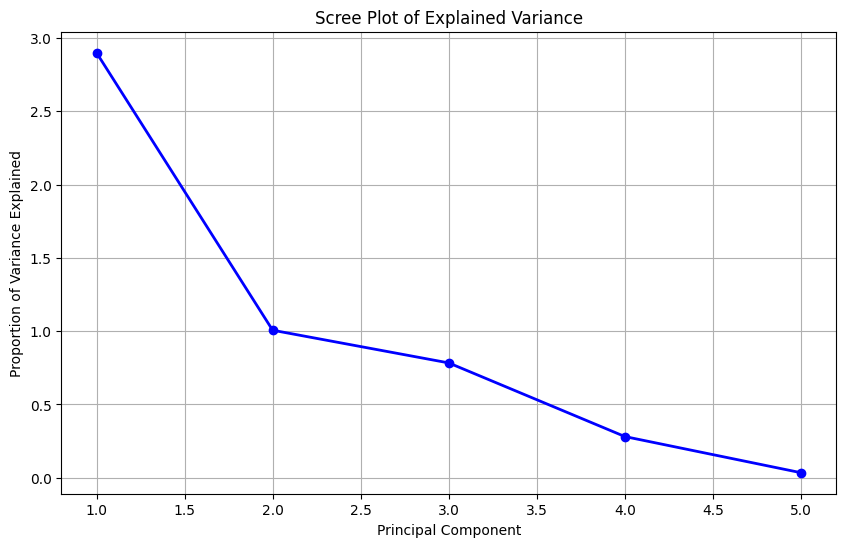

In [85]:
# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance2) + 1), explained_variance2, 'bo-', linewidth=2)
plt.title('Scree Plot of Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True)
plt.show()


### 3.j. How does the screeplot from the uncorrelated data compare with the screeplot from the government data?

This section is answered in the report pdf file.